In [62]:
!nvidia-smi

Fri Nov 11 17:18:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.141.03   Driver Version: 470.141.03   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
| 35%   55C    P8    40W / 350W |   1500MiB / 12031MiB |     43%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
import pandas as pd
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
data=pd.read_csv("result_interaction.csv")
interaction_array=np.array(data['Interaction'])
coordsx_array=np.array(data['x'])
coordsy_array=np.array(data['y'])

In [3]:
data

,Id,x,y,Expression,Action,Gesture,Interaction
0,person1,182,80,Neutral,Sitting,Down,Reading Book
1,person1,176,81,Neutral,Sitting,Down,Reading Book
2,person1,174,82,Neutral,Sitting,Down,Reading Book
3,person1,174,83,Neutral,Sitting,Down,Reading Book
4,person1,173,84,Neutral,Sitting,Down,Reading Book
...,...,...,...,...,...,...,...
151,person1,548,547,None,Sitting,Down,Calling on Phone
152,person1,558,543,None,Walking,Down,Holding Phone
153,person1,556,555,None,Walking,Down,Holding Phone
154,person1,549,548,None,Walking,Down,Holding Phone


/Users/haruhiro/opt/anaconda3/envs/mp4/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Value', ylabel='Density'>

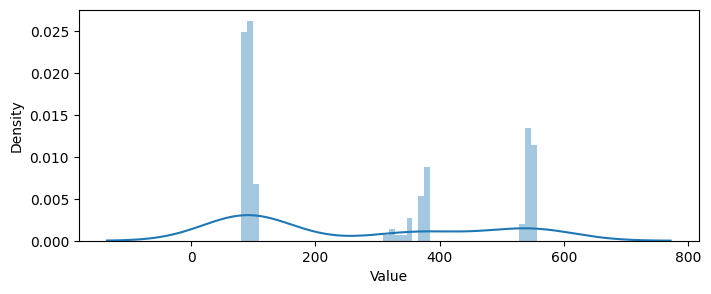

In [4]:
import seaborn as sns
x = data.iloc[:,2] 
K =3 #クラスタ数
l_1d = x.values.tolist()
l_1d
N = len(x) #観測データ数
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,1)
ax.set_xlabel("Value")
sns.distplot(l_1d, bins=50, ax=ax)

In [5]:
import pymc3 as pm
# 各確率変数の確率分布の定義
with pm.Model() as model:
  mu = pm.Normal('mu', mu=[100,380,500], sigma=1.2, shape=K) #平均はガウス分布
  tau = pm.Gamma('tau', alpha=10, beta=5, shape=K) #精度はガンマ分布
  pi = pm.Dirichlet('pi', a=np.ones(K), shape=K) #混合比率はディリクレ分布
  category = pm.Categorical('category', p=pi, shape=N) #クラスタ割り当てのパラメータはカテゴリカル分布
  x_var = pm.Normal('x', mu=mu[category], tau=tau[category], observed=l_1d) #xはガウス分布

In [6]:
# ギブスサンプリングによるパラメータ推論 
with model:
    step1 = pm.Metropolis(vars=[mu, tau, pi])
    step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1, 2])
    idata = pm.sample(10000, step=[step1, step2], tune=5000)

/var/folders/lh/8zrjls1x2ld2149mpkgmqgj40000gn/T/ipykernel_30728/3415785353.py:4: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  step2 = pm.ElemwiseCategorical(vars=[category], values=[0, 1, 2])
/Users/haruhiro/opt/anaconda3/envs/mp4/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CompoundStep
>>Metropolis: [pi]
>>Metropolis: [tau]
>>Metropolis: [mu]
>ElemwiseCategorical: [category]


/Users/haruhiro/opt/anaconda3/envs/mp4/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/Users/haruhiro/opt/anaconda3/envs/mp4/lib/python3.9/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 148 seconds.
/Users/haruhiro/opt/anaconda3/envs/mp4/lib/python3.9/site-packages/arviz/stats/diagnostics.py:586: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Got error No model on context stack. trying to find log_likelihood in translation.
/Users/haruhiro/opt/anaconda3/envs/mp4/lib/python3.9/site-packages/arviz/data/io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
Got error No model on context stack. trying to find log_likelihood in translation.


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'category'}>,
        <AxesSubplot:title={'center':'category'}>],
       [<AxesSubplot:title={'center':'tau'}>,
        <AxesSubplot:title={'center':'tau'}>],
       [<AxesSubplot:title={'center':'pi'}>,
        <AxesSubplot:title={'center':'pi'}>]], dtype=object)

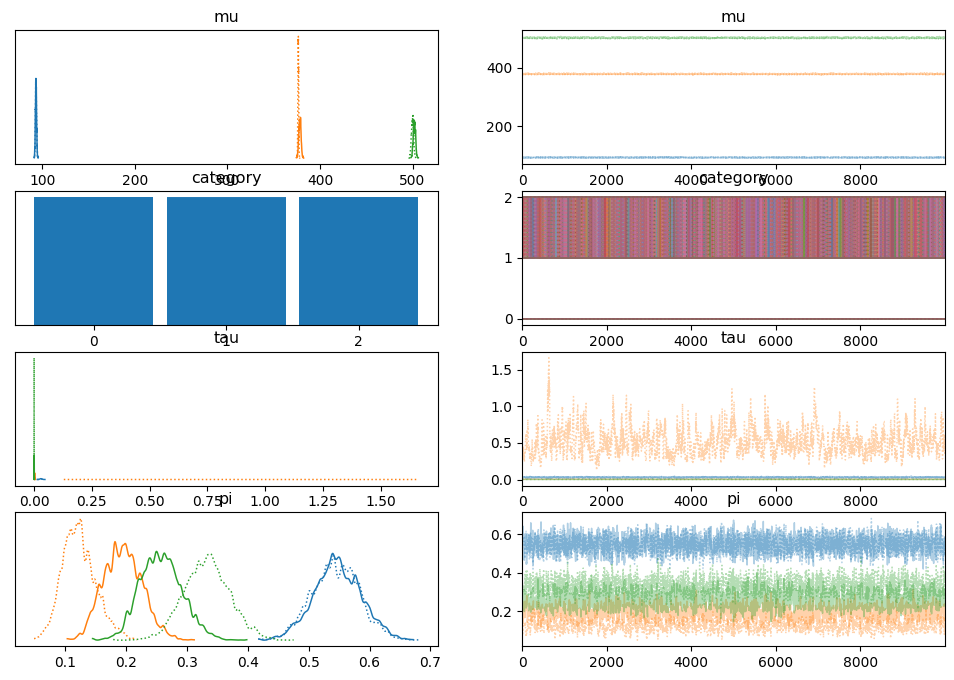

In [8]:
pm.plot_trace(idata) #各パラメータの事後分布の描画

In [9]:
from scipy import stats
# 所属クラスタのベイズ推論
def clustering(x, trace, n_sample = None):
    def likelihood(x, pi, mu, tau): 
      return pi * stats.norm.pdf(x, mu, 1./np.sqrt(tau)) 
    # 各パラメータの事後分布
    pi = trace['pi']
    mu = trace['mu']
    tau = trace['tau']
    slist = []
    if n_sample is None:
      n_sample = pi.shape[0] 
    for k in range(K): 
      s_k = list(map(lambda i:likelihood(x=x,pi=pi[i,k],mu=mu[i,k],tau=tau[i,k]),np.arange(n_sample))) 
      slist.append(s_k)
    #正規化
    slist = np.array(slist)
    nterm = slist.sum(axis=0) 
    p_k = (slist / nterm).T 
    return p_k

In [38]:
clustering(, idata, n_sample = None).mean(axis=0)

20000

10000
0 [1.00000000e+00 2.32656799e-30 3.36928140e-20]
1 [1.00000000e+00 1.39497652e-28 2.39722404e-19]
2 [1.00000000e+00 7.32145283e-26 2.44744398e-17]
3 [1.00000000e+00 3.36826162e-22 3.59058478e-14]
4 [9.99999999e-01 1.36902915e-17 7.60762094e-10]
5 [9.99772834e-01 5.71735878e-12 2.27166442e-04]
6 [0.87321011 0.00190539 0.1248845 ]
7 [0.24982961 0.07312946 0.67704093]
8 [0.01383424 0.13219206 0.8539737 ]
9 [3.71551796e-08 1.59541563e-01 8.40458400e-01]
10 [5.39947354e-16 1.89658388e-01 8.10341612e-01]
11 [1.59341158e-24 2.35333311e-01 7.64666689e-01]
12 [9.49710769e-34 2.94664589e-01 7.05335411e-01]
13 [1.13348181e-43 3.61367248e-01 6.38632752e-01]
14 [2.51172411e-54 4.38077911e-01 5.61922089e-01]
15 [7.06177874e-66 5.23459232e-01 4.76540768e-01]
16 [1.79680620e-78 6.16980021e-01 3.83019979e-01]
17 [7.00367213e-92 7.15145064e-01 2.84854936e-01]
18 [6.1296589e-106 8.0329874e-001 1.9670126e-001]
19 [1.30870281e-120 8.79646488e-001 1.20353512e-001]
20 [6.91052810e-136 9.41304372e-001 5

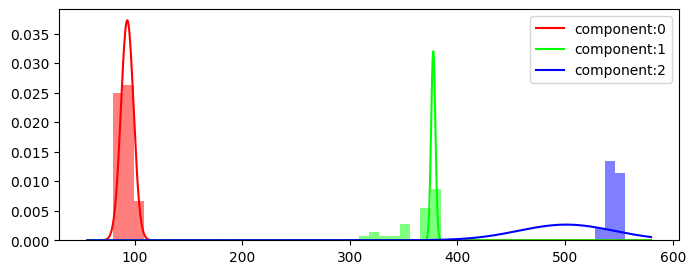

In [10]:
# データの描画
fig = plt.figure(figsize=(8, 3))
ax = fig.subplots(1,1)
vals, bins, patches = ax.hist(x, bins=50, density=True, alpha=0.5) 

# ビン毎の所属クラスタの確率
cluster_list = list(map(lambda x:clustering(x, idata, n_sample=1000).mean(axis=0),bins[1:]))
print(len(idata))
for i, p in enumerate(cluster_list): 
  patches[i].set_facecolor(p) #ビンに所属クラスタの色を描画
  print(i,p)
# 推論したパラメータの事後分布の平均を用いた所属クラスタの描画
xmin, xmax, ymin, ymax = ax.axis()
xl = np.linspace(xmin, xmax, 1000)
mpi = idata['pi'].mean(axis=0)
mmu = idata['mu'].mean(axis=0)
mtau = idata['tau'].mean(axis=0)
for k in range(K):
  pdf = mpi[k] * stats.norm(mmu[k], 1./np.sqrt(mtau[k])).pdf(xl)
  c = np.zeros(K)
  c[k] = 1
  ax.plot(xl, pdf, color=c, label='component:{}'.format(k))
ax.legend()

In [27]:
len(x)

156

In [28]:
aList = list(clustering(x, idata, n_sample=156).mean(axis=0))

In [29]:
len(aList)

156

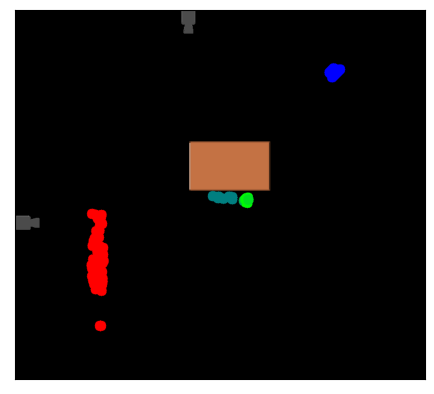

In [41]:
image=cv2.imread("ispace_frontier.png")
lambda x:clustering(x, idata, n_sample=1000).mean(axis=0)
for i in range(len(interaction_array)-1):
  xclass = clustering(x[i], idata, n_sample = None).mean(axis=0)
  if(interaction_array[i]!="None"):
    cv2.circle(image, (coordsy_array[i]+66, 671-coordsx_array[i]), 10, xclass*255, -1)

  plt.imshow(image)
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
ax.axes.yaxis.set_visible(False)
plt.imshow(image)